# Importacion de librerias y Dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from imblearn.over_sampling import SMOTE
drive.mount('/content/drive')
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# creo el obj dataframe con pandas
df = pd.read_csv("/content/drive/MyDrive/data_science/notebooks nuevas/Bank Marketing/data/bank-additional-full.csv",
                 delimiter=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# reemplazamos el string que denota datos nulos
# por un dato nulo
df = df.replace("unknown", np.nan)

In [4]:
df.shape

(41188, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
df.isna().mean()

age               0.000000
job               0.008012
marital           0.001942
education         0.042027
default           0.208726
housing           0.024036
loan              0.024036
contact           0.000000
month             0.000000
day_of_week       0.000000
duration          0.000000
campaign          0.000000
pdays             0.000000
previous          0.000000
poutcome          0.000000
emp.var.rate      0.000000
cons.price.idx    0.000000
cons.conf.idx     0.000000
euribor3m         0.000000
nr.employed       0.000000
y                 0.000000
dtype: float64

In [7]:
def generate_client_id(df_size):
  random_id = []
  len_df = df_size

  while True:
    random_id_tmp = np.random.randint(9e10, size=1)[0]
    if len(random_id) == len_df:
      break
    elif random_id_tmp not in random_id:
      random_id.append(random_id_tmp)

  if len(random_id) == len_df:
    return random_id
  else:
    return print("Error")

# generamos los id de los clientes
df["client_id"] = generate_client_id(len(df))

In [8]:
# checkeamos
display(df["client_id"].nunique(),
        len(df))

41188

41188

## Funciones auxiliares.

In [9]:
def calculate_prob_cond(df, A, B):
  '''
  Precondicion: A es el target (en este caso y = cliente no-sub o cliente sub).

  Funcion que calcula la probabilidad condicional P(A|B_i).
  Devuelve un dataframe en el cual se muestra el valor de P(A|B_i) para cada i
  donde B_i : El label UNICO i-esimo de la columna B
  '''
  df_copy = df[[A,B, "client_id"]].copy()

  df_result = pd.DataFrame()

  # calculo los ids de todos los clientes suscriptos a depositos
  p_a_ids = df_copy[df_copy[A] == "yes"]["client_id"].unique()

  list_p_a = []
  list_p_b = []
  list_p_a_y_b = []
  list_p_a_dado_b = []

  for label in df_copy[B].unique():

    list_p_a.append(len(p_a_ids)/df_copy.client_id.nunique())

    # calculo los ids de todos los clientes con label == label pertinente
    p_b_ids = df_copy[df_copy[B] == label]["client_id"].unique()
    list_p_b.append(len(p_b_ids)/df_copy.client_id.nunique())

    # calculo la probabilidad de la interseccion de a y b
    p_a_y_b = len(np.intersect1d(p_a_ids, p_b_ids))/df_copy.client_id.nunique()
    list_p_a_y_b.append(p_a_y_b)

    # calculo la probabilidad condicional
    p_a_dado_b = p_a_y_b/(len(p_b_ids)/df_copy.client_id.nunique())
    list_p_a_dado_b.append(p_a_dado_b)

  # construyo el df resultado
  df_result["label"] = df_copy[B].unique()
  df_result["P(A)"] = list_p_a
  df_result["P(B)"] = list_p_b
  df_result["P(A y B)"] = list_p_a_y_b
  df_result["P(A|B)"] = list_p_a_dado_b

  return df_result


def obtain_metrics(m, X_train, X_test, y_train, y_test):
  '''
  Funcion que devuelve las metricas asociadas a entrenar el modelo m
  con los datos de X_train e y_train produciendo las predicciones para X_test
  '''

  m.fit(X_train, y_train)

  y_pred = m.predict(X_test)

  # obtenemos las distintas metricas
  print(classification_report(y_test, y_pred))

  # matriz de confusion
  f=plt.figure(figsize=(3,3))
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,  fmt='g')

  print(f"Precisión (KNeighbors): {accuracy_score(y_test, y_pred)}")

  y_pred_prob = m.predict_proba(X_test)[:,1]

  # Calcular la curva ROC
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

  # Calcular el área bajo la curva ROC (AUC)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(3,3))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()

# EDA

  * **Variables continuas**.
    
    Las variables continuas en las que se descubrieron insights interesantes son:
    * ``euribor3m``
    * ``cons.price.idx``
    * ``cons.conf.idx``
    * ``capaigns``
    * ``pdays``
  
  * **Variables categoricas**.

   Las variables categoricas en las que se descubrieron insights interesantes son:
    * ``job``
    * ``education``
    * ``default``
    * ``poutcome``
    * ``emp.var.rate``

In [10]:
df_eda = df.copy()
print("Cantidad de clientes subs/no-subs \n \n", df_eda.y.value_counts(normalize=True))

Cantidad de clientes subs/no-subs 
 
 no     0.887346
yes    0.112654
Name: y, dtype: float64


## Variables Continuas

Al ver la cantidad de valores unicos por columna, parece ser una buena opcion tomar como valores numericos **continuos** aquellas columnas que superen los 11 valores unicos.

In [11]:
for col in df.columns:
  if df[col].dtype != np.object_:
    print(f"La columna {col} tiene {df[col].nunique()} valores unicos")

La columna age tiene 78 valores unicos
La columna duration tiene 1544 valores unicos
La columna campaign tiene 42 valores unicos
La columna pdays tiene 27 valores unicos
La columna previous tiene 8 valores unicos
La columna emp.var.rate tiene 10 valores unicos
La columna cons.price.idx tiene 26 valores unicos
La columna cons.conf.idx tiene 26 valores unicos
La columna euribor3m tiene 316 valores unicos
La columna nr.employed tiene 11 valores unicos
La columna client_id tiene 41188 valores unicos


In [12]:
# calculamos los features continuos y categoricos
cont_feats = [con_feat for con_feat in df_eda.columns if (df_eda[con_feat].dtype != np.object_) &
                                                         (df_eda[con_feat].nunique() > 11)]

cat_feats = [cat_feat for cat_feat in df_eda.columns if cat_feat not in cont_feats]

**OBS:** Cuando discriminamos a los clientes deacuerdo si suscribieron o no, al deposito, parece haber una diferencia en la distribucion de las variables:
* **cons.price.idx**.
* **cons.conf.idx**.
* **euribor3m**.

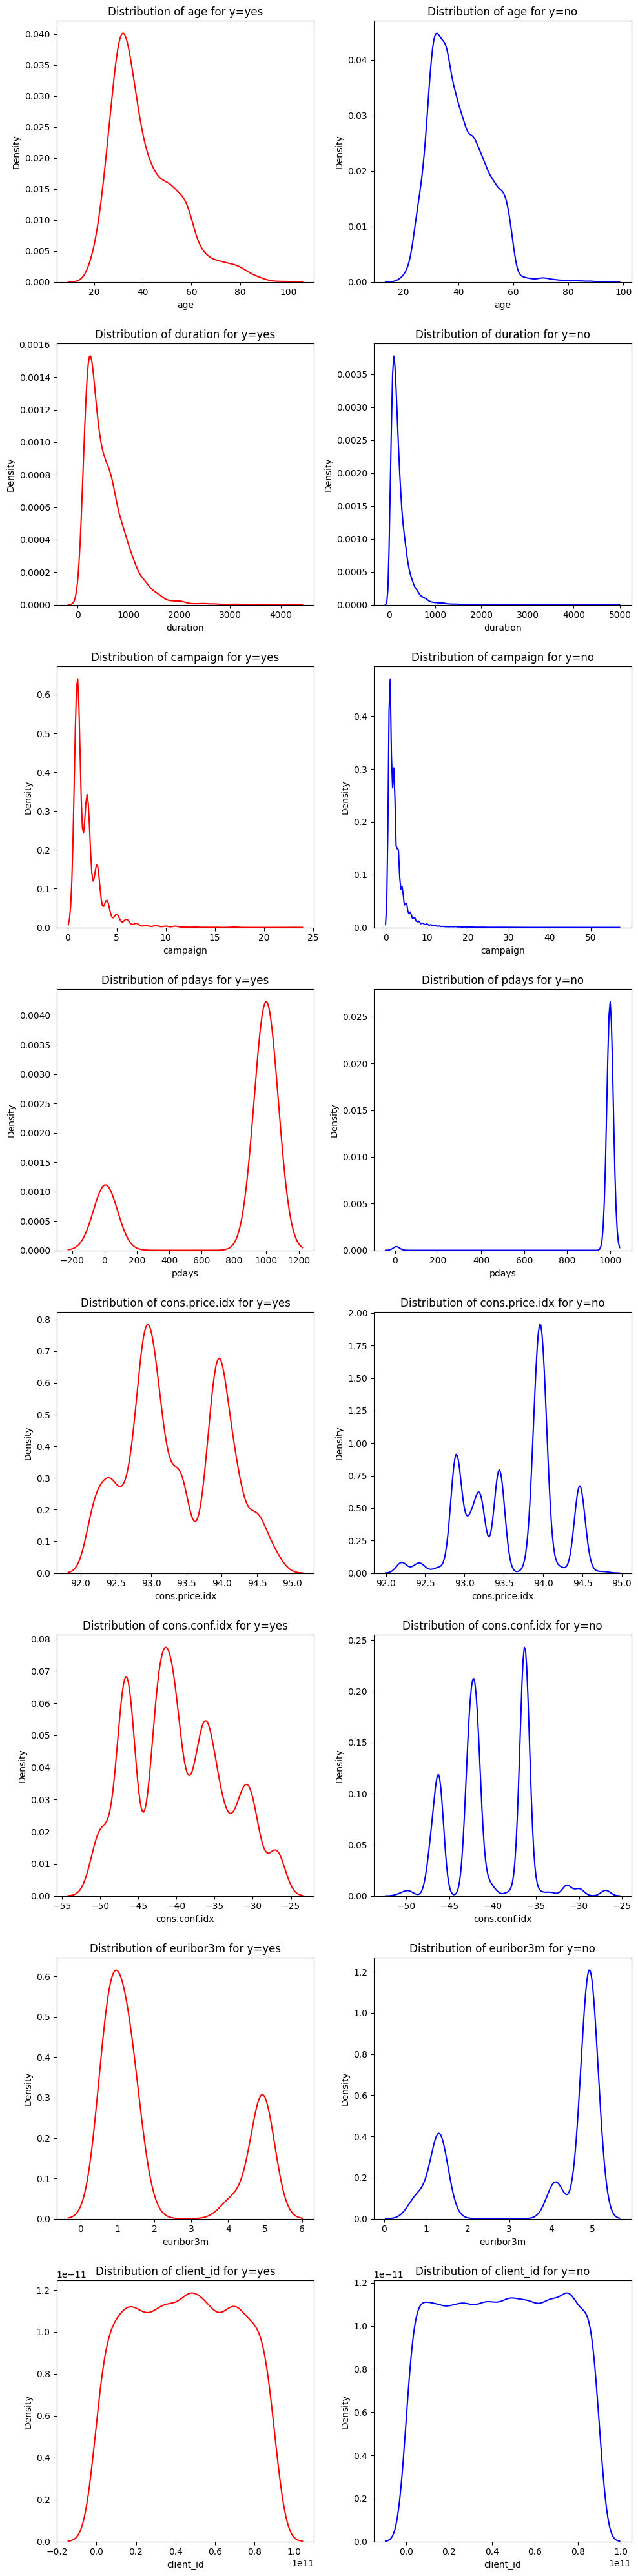

In [13]:
# Suponiendo que df_eda es tu DataFrame y 'cont_feats' es una lista de las características continuas.
df_eda_yes = df_eda[df_eda["y"] == "yes"]
df_eda_no = df_eda[df_eda["y"] == "no"]

# Calcula el número de filas necesario para el número de características.
# Cada característica necesita su propia fila en la cuadrícula de subtramas.
num_rows = len(cont_feats)

# Ajusta el tamaño de la figura (ancho, alto) para que se acomode el número de subgráficos.
fig, axs = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))

for idx, con_feat in enumerate(cont_feats):
    sns.kdeplot(df_eda_yes, x=con_feat, ax=axs[idx][0], color="red")
    sns.kdeplot(df_eda_no, x=con_feat, ax=axs[idx][1], color="blue")
    axs[idx][0].set_title(f'Distribution of {con_feat} for y=yes')
    axs[idx][1].set_title(f'Distribution of {con_feat} for y=no')

# Ajusta el layout para evitar la sobreposición de títulos y etiquetas.
plt.tight_layout()
plt.show()

In [14]:
euribor_per_month_mean = df_eda.groupby("month")["euribor3m"].mean()\
                               .reset_index().rename(columns={"euribor3m": "euribor3m_mean"})
euribor_per_month_mean

,month,euribor3m_mean
0,apr,1.361070
1,aug,4.300623
2,dec,0.865319
3,jul,4.685678
4,jun,4.256908
5,mar,1.162745
6,may,3.293665
7,nov,3.723123
8,oct,1.200123
9,sep,0.834760


Text(0, 0.5, 'AVG(Euribor)')

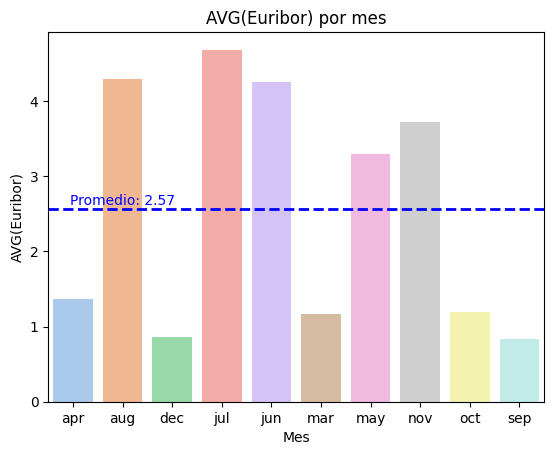

In [15]:
ax=sns.barplot(euribor_per_month_mean, x="month",
              y="euribor3m_mean", palette="pastel")

euribor_mean = euribor_per_month_mean.euribor3m_mean.mean()

# Añades la línea horizontal para la media
ax.axhline(y=euribor_mean, color='blue', linestyle='--', linewidth=2)

# Añades anotación para la línea de la media, opcional
ax.text(1, euribor_mean + 0.1, f'Promedio: {euribor_mean:.2f}', color='blue', va='center', ha='center')
ax.set_title("AVG(Euribor) por mes")
ax.set_xlabel("Mes")
ax.set_ylabel("AVG(Euribor)")

In [16]:
# damos un orden a los meses
month_map = {"mar" : 3,
             "apr": 4,
             "may" : 5,
             "jun": 6,
             "jul": 7,
             "aug": 8,
             "sep": 9,
             "oct": 10,
             "nov": 11,
             "dec": 12}

# guardamos el orden de los meses
order_months = month_map.keys()

# casteamos la variable month como categorica con orden
df_eda.month = pd.Categorical(df_eda['month'], categories=order_months, ordered=True)

**% MENSUAL DE EURIBOR Y CANTIDAD DE SUSCRPICIONES A DEPOSITOS**

In [17]:
# calculamos los meses con un euribor3m_mean menor a la media
# (ie meses con tasa de interes mas baja que el promedio)
month_w_smll_euribor = euribor_per_month_mean[euribor_per_month_mean.euribor3m_mean < euribor_mean]["month"]

# creamos una crosstable con los meses y la cantidad de suscripciones y no suscripciones a depositos
qty_subs_per_month = pd.crosstab(index=df_eda['month'], columns=df_eda['y'], colnames=[''])
qty_subs_per_month . columns = ["nosub-client", "sub-client"]
qty_subs_per_month = qty_subs_per_month.reset_index()

# damos orden a la variable categorica month
qty_subs_per_month.month = pd.Categorical(qty_subs_per_month['month'], categories=order_months, ordered=True)
qty_subs_per_month["euribor"] = np.where(qty_subs_per_month.month.isin(month_w_smll_euribor),
                                         "below than mean", "higher than mean")

qty_subs_per_month

,month,nosub-client,sub-client,euribor
0,mar,270,276,below than mean
1,apr,2093,539,below than mean
2,may,12883,886,higher than mean
3,jun,4759,559,higher than mean
4,jul,6525,649,higher than mean
5,aug,5523,655,higher than mean
6,sep,314,256,below than mean
7,oct,403,315,below than mean
8,nov,3685,416,higher than mean
9,dec,93,89,below than mean


**OBS:**

Tiene sentido pensar que si el indicador **euribor** se encuentra en un valor mas alto que la media, haya mas interesados en hacer depositos y "aprovechar" una tasa de interes mas alta que la media.

Text(0, 0.5, 'Cantidad de suscripciones')

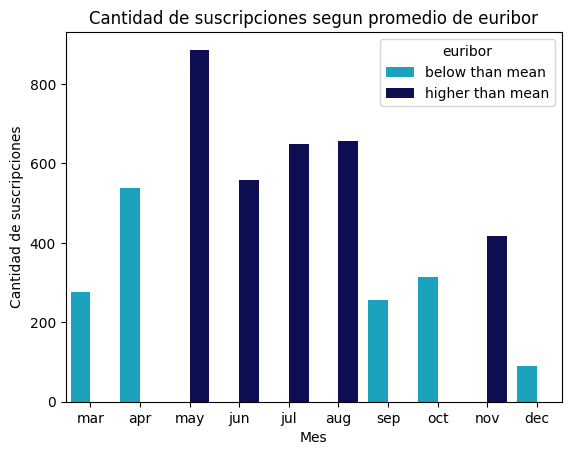

In [18]:
ax=sns.barplot(qty_subs_per_month, x="month", hue="euribor",
               y="sub-client", palette=["#00b4d8", "#03045e"])

ax.set_title("Cantidad de suscripciones segun promedio de euribor")
ax.set_xlabel("Mes")
ax.set_ylabel("Cantidad de suscripciones")

**CONS PRICE IDX**

Text(0, 0.5, 'Tipo cliente: suscrito/no-suscrito)')

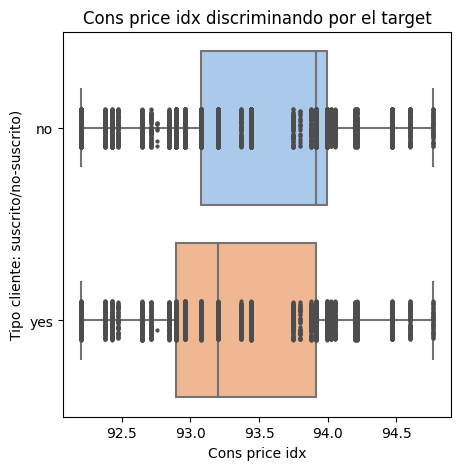

In [19]:
plt.figure(figsize=(5,5))
ax=sns.boxplot(df_eda, x="cons.price.idx", y="y", palette="pastel")
sns.stripplot(df_eda, x="cons.price.idx", y="y", size=3, color=".3", ax=ax)

ax.set_title("Cons price idx discriminando por el target")
ax.set_xlabel("Cons price idx")
ax.set_ylabel("Tipo cliente: suscrito/no-suscrito)")

In [20]:
# calculamos la media de cons.pric.idx por mes
cons_price_idx_per_month = df_eda.groupby("month")["cons.price.idx"].mean()\
                                 .reset_index()

# mergeamos para poder obtener el valor de euribor dicho mes
qty_subs_cons_price_idx_per_month = pd.merge(qty_subs_per_month,
                                            cons_price_idx_per_month,
                                            how="left", on="month")

qty_subs_cons_price_idx_per_month

,month,nosub-client,sub-client,euribor,cons.price.idx
0,mar,270,276,below than mean,93.097330
1,apr,2093,539,below than mean,93.119558
2,may,12883,886,higher than mean,93.528882
3,jun,4759,559,higher than mean,94.245402
4,jul,6525,649,higher than mean,93.894923
5,aug,5523,655,higher than mean,93.311065
6,sep,314,256,below than mean,93.346474
7,oct,403,315,below than mean,93.175107
8,nov,3685,416,higher than mean,93.200943
9,dec,93,89,below than mean,92.715363


**OBS:**

Hay una relacion lineal entre la variable **cons.price.idx** y **la cantidad de suscripciones a depositos** determinados por la variable **euribor**.

i.e

* Cuando **euribor** toma el valor `higher than mean` (ese decir, cuando la tasa de interes es mayor al promedio registrado hasta el momento) $\Rightarrow$ la cantidad de suscripciones y el cons price idx **es mayor**

* Cuando **euribor** toma el valor `below than mean` (Caso contrario) $\Rightarrow$ la cantidad de suscripciones y el cons price idx **es menor**.

</br>

El "Cons Price Index" (Índice de Precios al Consumidor, IPC) es una medida económica que evalúa el costo promedio de una canasta de bienes y servicios consumidos por los hogares.

Por lo que **un aumento en el euribor podria implicar** un aumento de inflacion lo que **podria concluir en un aumento** de los precios al consumidor (cons price idx).

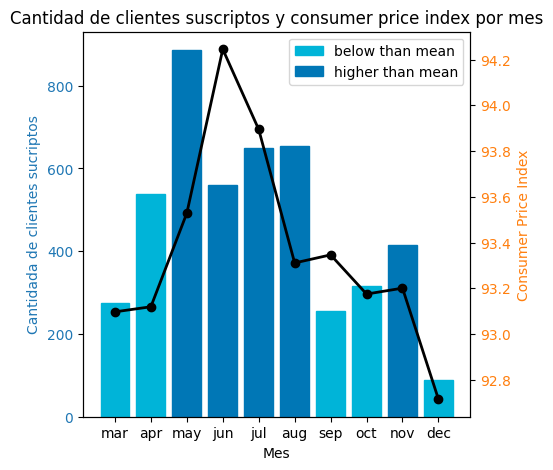

In [21]:
fig, ax1 = plt.subplots(figsize=(5, 5))

# ploteamos la cantidad de subs en un eje
color = 'tab:blue'
ax1.set_xlabel('Mes')
ax1.set_ylabel('Cantidada de clientes sucriptos', color=color)
bar1 = ax1.bar(qty_subs_cons_price_idx_per_month['month'],
               qty_subs_cons_price_idx_per_month['sub-client'],
               color=color)

ax1.tick_params(axis='y', labelcolor=color)

# seteamos colores diferentes segun el valor de la columna euribor
for i, bar in enumerate(bar1):
    if qty_subs_cons_price_idx_per_month['euribor'][i] == "higher than mean":
        bar.set_color("#0077b6")
        bar.set_label("higher than mean")
    else:
        bar.set_color("#00b4d8")
        bar.set_label("below than mean")

# creamos en el otro eje un lineplot con el valor promedio de cons.price.idx por mes
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Consumer Price Index', color=color)

ax2.plot(qty_subs_cons_price_idx_per_month['month'].sort_values(),
         qty_subs_cons_price_idx_per_month.sort_values(by="month")['cons.price.idx'],
         color='black', linewidth=2, marker='o')

ax2.tick_params(axis='y', labelcolor=color)

plt.title('Cantidad de clientes suscriptos y consumer price index por mes')
# Agregamos leyendas
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Elimina duplicados
ax1.legend(by_label.values(), by_label.keys())

plt.show()

Text(0, 0.5, 'Cantidad de suscripciones a depositos')

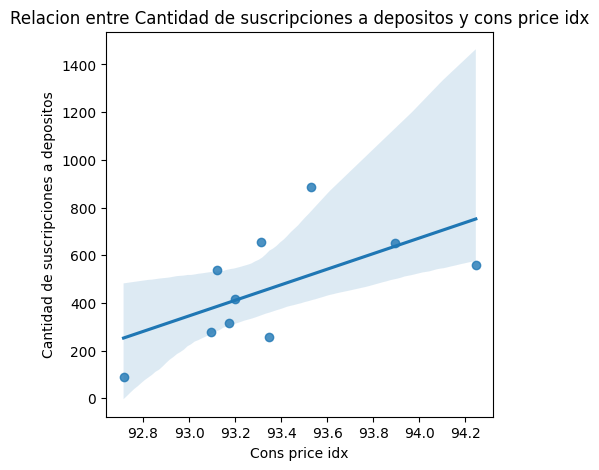

In [22]:
plt.figure(figsize=(5,5))
ax = sns.regplot(qty_subs_cons_price_idx_per_month.sort_values("month"),
                 x="cons.price.idx" , y="sub-client")

ax.set_title("Relacion entre Cantidad de suscripciones a depositos y cons price idx")
ax.set_xlabel("Cons price idx")
ax.set_ylabel("Cantidad de suscripciones a depositos")

**CONS CONF IDX**

Text(0, 0.5, 'Tipo cliente: suscrito/no-suscrito)')

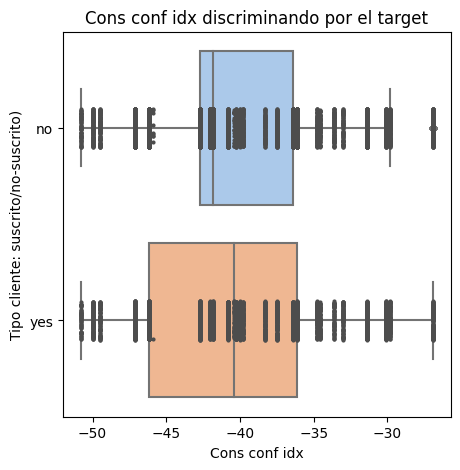

In [23]:
plt.figure(figsize=(5,5))
ax=sns.boxplot(df_eda, x="cons.conf.idx", y="y", palette="pastel")
sns.stripplot(df_eda, x="cons.conf.idx", y="y", size=3, color=".3", ax=ax)

ax.set_title("Cons conf idx discriminando por el target")
ax.set_xlabel("Cons conf idx")
ax.set_ylabel("Tipo cliente: suscrito/no-suscrito)")

In [24]:
# calculamos la media de cons.conf.idx por mes
cons_conf_idx_per_month = df_eda.groupby("month")["cons.conf.idx"].mean()\
                                 .reset_index()

# mergeamos para obtner otros valores agregados por mes
qty_subs_cons_conf_idx_per_month = pd.merge(qty_subs_per_month,
                                            cons_conf_idx_per_month,
                                            how="left", on="month")

qty_subs_cons_conf_idx_per_month

,month,nosub-client,sub-client,euribor,cons.conf.idx
0,mar,270,276,below than mean,-42.650549
1,apr,2093,539,below than mean,-46.273632
2,may,12883,886,higher than mean,-40.579272
3,jun,4759,559,higher than mean,-41.579428
4,jul,6525,649,higher than mean,-42.370170
5,aug,5523,655,higher than mean,-35.597184
6,sep,314,256,below than mean,-33.893158
7,oct,403,315,below than mean,-34.580919
8,nov,3685,416,higher than mean,-41.238747
9,dec,93,89,below than mean,-33.708791


**OBS:**

En cuanto a la variable **cons.conf.idx** tambien pareciera haber cierta relacion lineal, aunque en este caso **dicha relacion pareciera ser negativa**.

Text(0, 0.5, 'Cantidad de suscripciones a depositos')

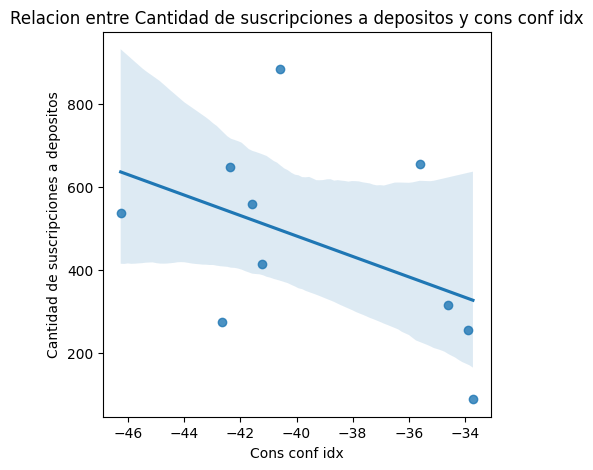

In [25]:
plt.figure(figsize=(5,5))
ax = sns.regplot(qty_subs_cons_conf_idx_per_month.sort_values("month"),
                 x="cons.conf.idx" , y="sub-client")

ax.set_title("Relacion entre Cantidad de suscripciones a depositos y cons conf idx")
ax.set_xlabel("Cons conf idx")
ax.set_ylabel("Cantidad de suscripciones a depositos")

**CAMPAÑAS**

In [26]:
# calculamos la cantidad de camapanas por mes
qty_campaigns_per_month = df_eda.groupby("month")["campaign"].sum()\
                                                             .reset_index()\
                                                             .rename(columns={"campaign": "total_campaign_month"})\
                                                             .sort_values("month")

# unimos con la cantidad de suscripciones por mes
qty_campaignsANDsubs_per_month = pd.merge(qty_subs_per_month,
                                          qty_campaigns_per_month,
                                          how="left", on="month")

qty_campaignsANDsubs_per_month

,month,nosub-client,sub-client,euribor,total_campaign_month
0,mar,270,276,below than mean,1203
1,apr,2093,539,below than mean,5125
2,may,12883,886,higher than mean,33593
3,jun,4759,559,higher than mean,16338
4,jul,6525,649,higher than mean,22677
5,aug,5523,655,higher than mean,16474
6,sep,314,256,below than mean,1011
7,oct,403,315,below than mean,1110
8,nov,3685,416,higher than mean,7830
9,dec,93,89,below than mean,393


**OBS:**

Vemos que en los meses con mayores suscripciones a depositos **tmb hubo maximos** en el **promedio de campañas realizadas**

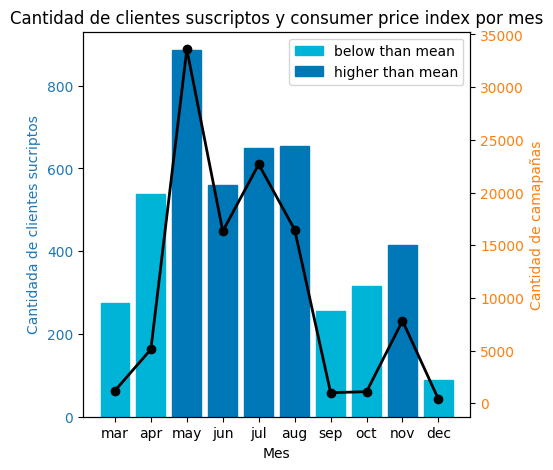

In [27]:
fig, ax1 = plt.subplots(figsize=(5, 5))

# ploteamos la cantidad de subs en un eje
color = 'tab:blue'
ax1.set_xlabel('Mes')
ax1.set_ylabel('Cantidada de clientes sucriptos', color=color)
bar1 = ax1.bar(qty_campaignsANDsubs_per_month['month'],
               qty_campaignsANDsubs_per_month['sub-client'],
               color=color)

ax1.tick_params(axis='y', labelcolor=color)

# seteamos colores diferentes segun el valor de la columna euribor
for i, bar in enumerate(bar1):
    if qty_campaignsANDsubs_per_month['euribor'][i] == "higher than mean":
        bar.set_color("#0077b6")
        bar.set_label("higher than mean")
    else:
        bar.set_color("#00b4d8")
        bar.set_label("below than mean")

# creamos en el otro eje un lineplot con el valor promedio de cons.price.idx por mes
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Cantidad de camapañas', color=color)

ax2.plot(qty_campaignsANDsubs_per_month['month'].sort_values(),
         qty_campaignsANDsubs_per_month.sort_values(by="month")['total_campaign_month'],
         color='black', linewidth=2, marker='o')

ax2.tick_params(axis='y', labelcolor=color)

plt.title('Cantidad de clientes suscriptos y consumer price index por mes')

# Agregamos leyendas
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Elimina duplicados
ax1.legend(by_label.values(), by_label.keys())

plt.show()

**PDAYS**

<Axes: >

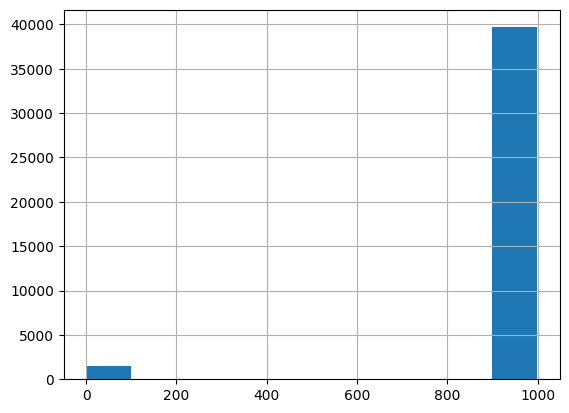

In [28]:
# el numero 999 denota que el cliente no fue previamente contactado
df_eda.pdays.hist()

**Analizamos solo clientes contactados**

In [29]:
# obtenemos solo clientes contactados
only_contacted_df = df_eda[df_eda.pdays != 999].copy()

# Definimos los bins para los 7 intervalos
bins = [0, 3, 7, np.inf]

# Creamos etiquetas para los intervalos para una mejor interpretación
interval_labels = ['0-3', '4-7', '7+']

# Usamos pd.cut para clasificar los valores en los bins
# El parámetro include_lowest=True asegura que el primer intervalo sea cerrado por ambos lados
categories = pd.cut(only_contacted_df.pdays.unique(), bins=bins, labels=interval_labels, include_lowest=True)

# Creamos un DataFrame para ver los resultados más claramente
df_intervals = pd.DataFrame({'values': only_contacted_df.pdays.unique(),
                             'pdays_bin': categories})

# combinamos para obtener pdays_interval
only_contacted_df=pd.merge(only_contacted_df, df_intervals, how="left", left_on="pdays" ,right_on="values")

In [30]:
only_contacted_df.pdays_bin.value_counts()

4-7    636
0-3    541
7+     338
Name: pdays_bin, dtype: int64

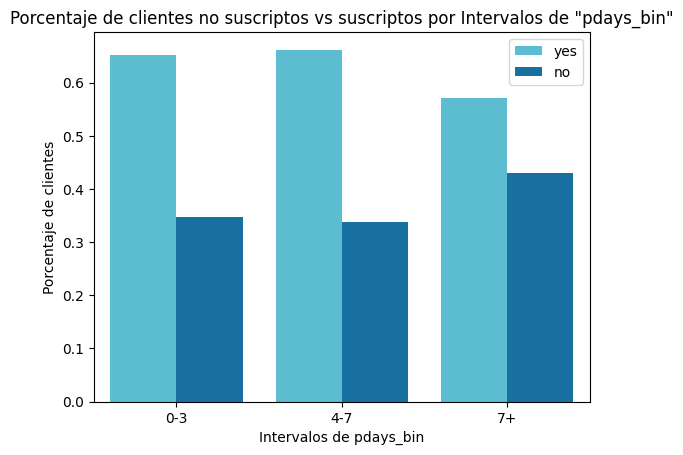

In [31]:
# calculamos la cantidad de suscriptos por intervalo de pdays_bin
ax = sns.barplot(only_contacted_df.groupby(by="pdays_bin")["y"].value_counts(normalize=True)\
                                   .reset_index(name="target_mean"),
                 palette=["#48cae4", "#0077b6"],
                 x="pdays_bin", y="target_mean", hue="y")

ax.set_title('Porcentaje de clientes no suscriptos vs suscriptos por Intervalos de "pdays_bin"')
ax.set_xlabel('Intervalos de pdays_bin')
ax.set_ylabel('Porcentaje de clientes')
ax.legend(bbox_to_anchor=(1., 1.))
plt.show()

In [32]:
# calculamos la probabilidad condicional
prob_cond_result=calculate_prob_cond(only_contacted_df, "y", "pdays_bin")
prob_cond_result

,label,P(A),P(B),P(A y B),P(A|B)
0,4-7,0.638284,0.419802,0.277888,0.661950
1,0-3,0.638284,0.357096,0.233003,0.652495
2,7+,0.638284,0.223102,0.127393,0.571006


Text(0, 0.5, 'Probabilidad de suscripcion dada \n la prob de haber sido contactado hace x dias')

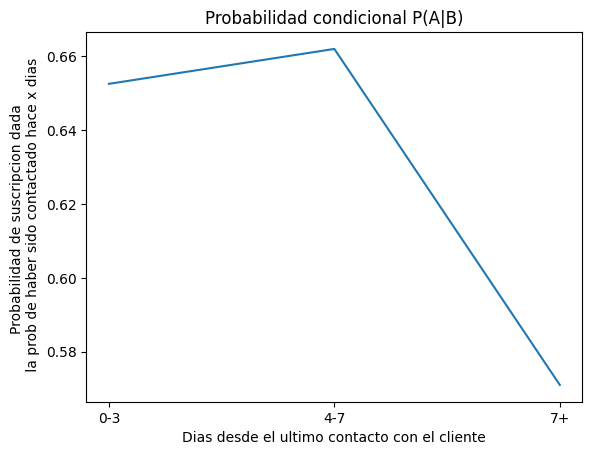

In [33]:
ax=sns.lineplot(prob_cond_result,
               x="label", y="P(A|B)")

ax.set_title("Probabilidad condicional P(A|B)")
ax.set_xlabel("Dias desde el ultimo contacto con el cliente")
ax.set_ylabel("Probabilidad de suscripcion dada \n la prob de haber sido contactado hace x dias")

## Variables Categoricas

**JOB**

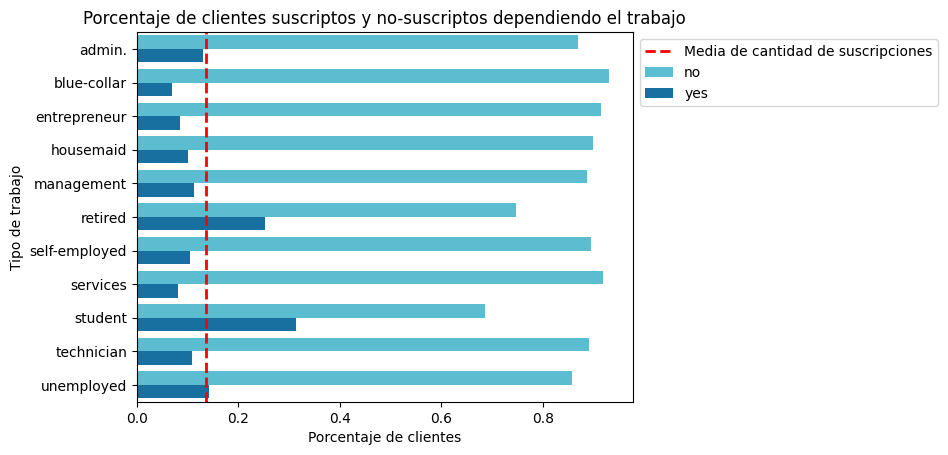

In [34]:
# calculamos el procentaje de no-sus/sus
target_mean_gp_job = df_eda.groupby("job")["y"].value_counts(normalize=True)\
                           .reset_index(name="target mean")

ax=sns.barplot(target_mean_gp_job,
                y="job", x= "target mean", hue="y",
                palette=["#48cae4", "#0077b6"])

# añadimos una linea para denotar la mediana de cantidad de suscripciones
ax.axvline(x=target_mean_gp_job[target_mean_gp_job.y=="yes"]\
                               ["target mean"].mean(),
           color='red', linestyle='--', linewidth=2,
           label="Media de cantidad de suscripciones")

ax.set_title("Porcentaje de clientes suscriptos y no-suscriptos dependiendo el trabajo")
ax.set_ylabel("Tipo de trabajo")
ax.set_xlabel("Porcentaje de clientes")
ax.legend(bbox_to_anchor=(1, 1.))

In [35]:
prob_cond_result_3 = calculate_prob_cond(df_eda[~df_eda.job.isna()], "y", "job")
prob_cond_result_3

,label,P(A),P(B),P(A y B),P(A|B)
0,housemaid,0.112658,0.025944,0.002594,0.100000
1,services,0.112658,0.097141,0.007905,0.081381
2,admin.,0.112658,0.255079,0.033090,0.129726
3,blue-collar,0.112658,0.226492,0.015615,0.068943
4,technician,0.112658,0.165035,0.017867,0.108260
5,retired,0.112658,0.042097,0.010622,0.252326
6,management,0.112658,0.071565,0.008028,0.112175
7,unemployed,0.112658,0.024818,0.003524,0.142012
8,self-employed,0.112658,0.034779,0.003647,0.104856
9,entrepreneur,0.112658,0.035636,0.003035,0.085165


**OBS:**

Si bien al parecer hay trabajos relacionados a probabilidades condicionales mas altas esto no implica que realmente sea asi, ya que tenemos mucha disparidad en el `value_counts()` de la columna **job**

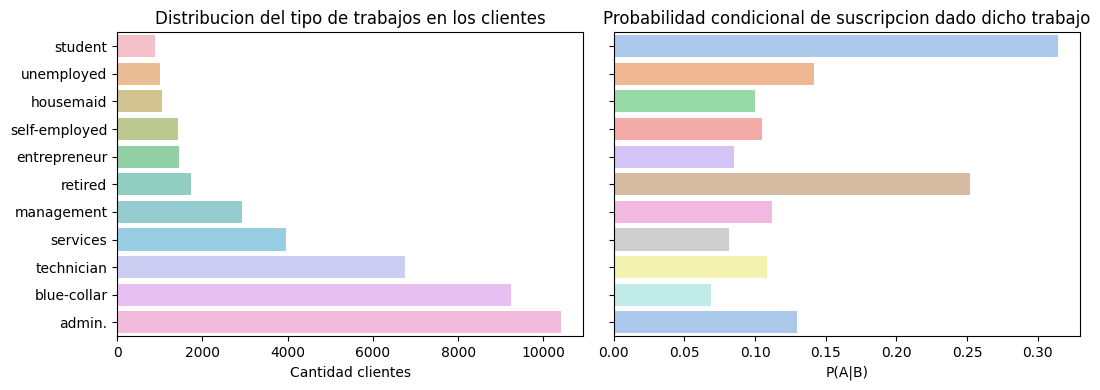

In [36]:
# creamos dos graficos de barras para la columna job
# uno para indicar la cantidad de ocurrencias en dicho label
# otro para indicar la P(A|B)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

# Gráfico de barras para el value_counts en el primer eje
job_counts = df_eda[~df_eda.job.isna()]["job"].value_counts().sort_values()
sns.barplot(x=job_counts.values, y=job_counts.index, alpha=0.6, ax=ax1)
ax1.set_xlabel('Cantidad clientes')
ax1.set_title('Distribucion del tipo de trabajos en los clientes')

# Barplot para la probabilidad condicional en el segundo eje
sorted_probs = prob_cond_result_3.set_index('label').reindex(job_counts.index)['P(A|B)']
sns.barplot(x=sorted_probs.values, y=sorted_probs.index, palette='pastel', ax=ax2)
ax2.set_xlabel('P(A|B)')
ax2.set_title('Probabilidad condicional de suscripcion dado dicho trabajo')

plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()

**EDUCATION**

In [37]:
df_eda.education.unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', nan, 'university.degree', 'illiterate'],
      dtype=object)

In [38]:
# damos un orden al nivel de educacion
education_map = {"illiterate": 1,
                "basic.4y" : 2,
                "basic.6y": 3,
                "basic.9y" : 4,
                "high.school": 5,
                "professional.course": 6,
                "university.degree": 7}

# guardamos el orden del nivel de educacion
order_education = education_map.keys()

# casteamos la variable education como categorica con orden
df_eda.education= pd.Categorical(df_eda['education'], categories=order_education, ordered=True)

**OBS:**

Vemos que si bien NO pareciera haber una diferencia notoria en porcentaje de no-subs/subs cuando discriminamos por nivel de educacion, el **label que presenta un porcentaje mayor de suscripciones** a depositos es el que representa a aquellos **clientes que poseen un nivel muy bajo en lo que refiere a educacion.**

Pendiente: Prueba de hipotesis.

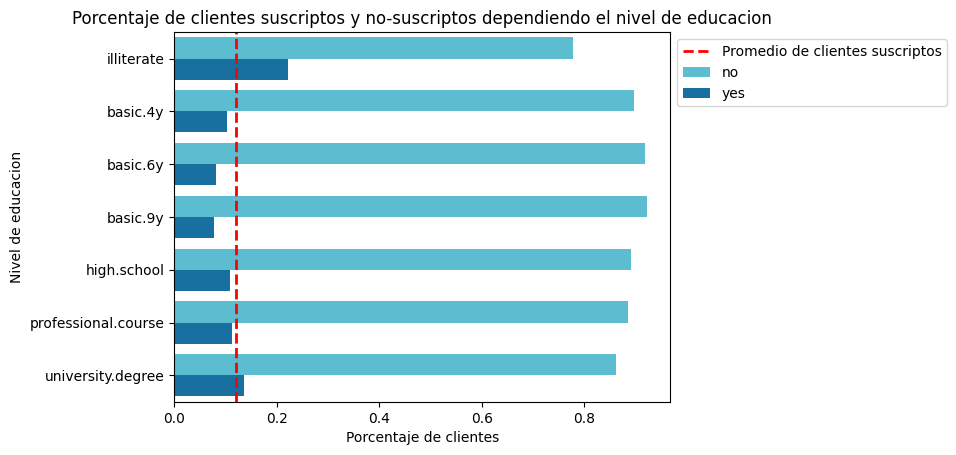

In [39]:
# calculamos la cantidad de no-sus/sus por nivel educativo de los clientes
target_mean_gp_education = df_eda.groupby("education")["y"].value_counts(normalize=True)\
                                  .reset_index(name="target mean")\

ax=sns.barplot(target_mean_gp_education,
              palette=["#48cae4", "#0077b6"],
              y="education", x="target mean", hue="y"
              )
# añadimos una linea vertical para remarcar la media de suscripciones
ax.axvline(x=target_mean_gp_education[target_mean_gp_education.y=="yes"]\
                                      ["target mean"].mean(),
           color='red', linestyle='--', linewidth=2,
           label="Promedio de clientes suscriptos")

ax.set_title("Porcentaje de clientes suscriptos y no-suscriptos dependiendo el nivel de educacion")
ax.set_xlabel("Porcentaje de clientes")
ax.set_ylabel("Nivel de educacion")
ax.legend(bbox_to_anchor=(1, 1.0))

**DEFAULT**

**OBS:**

Vemos que los clientes que **tienen mora** NO se suscriben al deposito, algo que a priori es bastante logico de pensar.

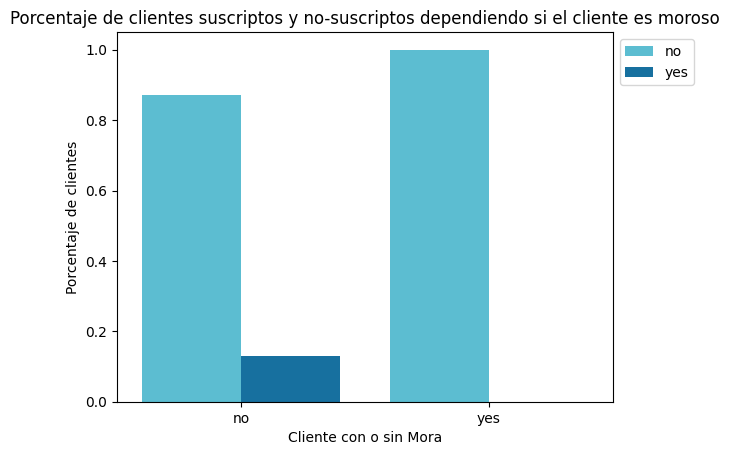

In [40]:
# calculamos la cantidad de no-sus/sus por valor de default
ax=sns.barplot(df_eda.groupby("default")["y"].value_counts(normalize=True)\
                                             .reset_index(name="target mean"),
               x="default", y="target mean", hue="y",
               palette=["#48cae4", "#0077b6"])

ax.set_title("Porcentaje de clientes suscriptos y no-suscriptos dependiendo si el cliente es moroso")
ax.set_xlabel("Cliente con o sin Mora")
ax.set_ylabel("Porcentaje de clientes")
ax.legend(bbox_to_anchor=(1, 1.0))

**POUTCOME**

**OBS:**

Tiene sentido pensar que si la camapaña anterior tuvo exito para un determinado grupo de clientes $\Rightarrow$ tenga mas probabilidad de volver a tener exito en los mismos clientes.

Text(0.5, 0, 'Exito de campaña previa del cliente')

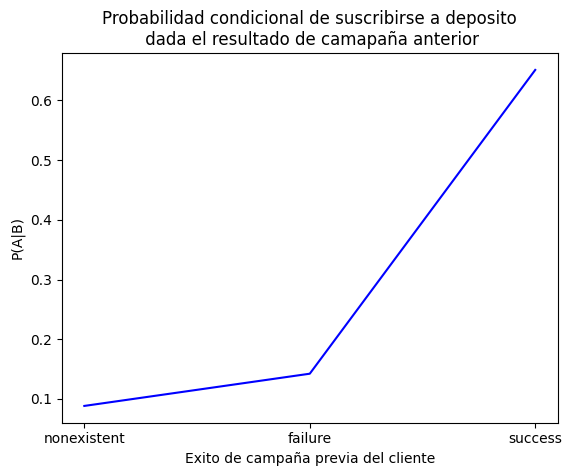

In [41]:
prob_cond_result_4= calculate_prob_cond(df_eda, "y","poutcome")

ax = sns.lineplot(prob_cond_result_4, color="b",
                  x="label", y="P(A|B)")

ax.set_title("Probabilidad condicional de suscribirse a deposito\n dada el resultado de camapaña anterior")
ax.set_ylabel("P(A|B)")
ax.set_xlabel("Exito de campaña previa del cliente")

**EMPO VAR RATE**

In [42]:
test_emp_var_rate = df_eda.copy()

test_emp_var_rate.y = np.where(test_emp_var_rate.y == "yes", 1, 0)

test_emp_var_rate_gb = test_emp_var_rate.groupby("month").agg({"emp.var.rate": "mean",
                                                               "y": "mean"})
test_emp_var_rate_gb=  test_emp_var_rate_gb.reset_index()

# joineamos para saber que tasa de euribor hubo dicho mes
test_emp_var_rate_gb = pd.merge(test_emp_var_rate_gb,
                                qty_subs_per_month[["month", "euribor"]],
                                on="month", how="left")

test_emp_var_rate_gb.head()

,month,emp.var.rate,y,euribor
0,mar,-1.800000,0.505495,below than mean
1,apr,-1.800000,0.204787,below than mean
2,may,-0.164972,0.064347,higher than mean
3,jun,0.688379,0.105115,higher than mean
4,jul,1.158921,0.090466,higher than mean


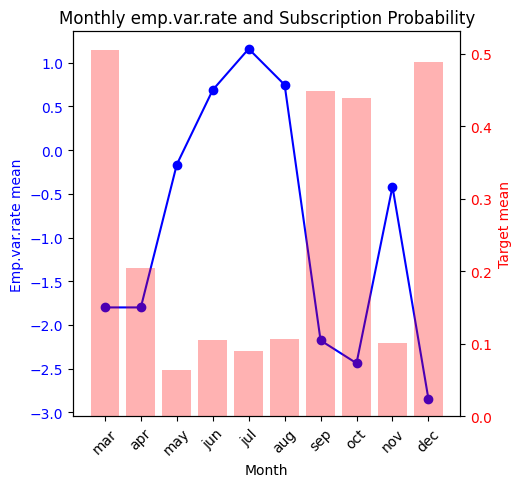

In [43]:
fig, ax1 = plt.subplots(figsize=(5, 5))

months = test_emp_var_rate_gb.month.unique()

# seteo el eje x con los meses
ax1.set_xticks(range(len(months)))
ax1.set_xticklabels(months, rotation=45)

# ploteo 'emp.var.rate' como un gráfico de líneas en el primer eje
ax1.plot(test_emp_var_rate_gb['emp.var.rate'], color='b', marker='o')
ax1.set_xlabel('Month')
ax1.set_ylabel('Emp.var.rate mean', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Crear el segundo eje que comparte el mismo eje x
ax2 = ax1.twinx()

# ploteo 'y' como un gráfico de barras en el segundo eje
ax2.bar(months, test_emp_var_rate_gb['y'], alpha=0.3, color='r')
ax2.set_ylabel('Target mean', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Monthly emp.var.rate and Subscription Probability')

plt.show()

In [44]:
test_emp_var_rate_gb

,month,emp.var.rate,y,euribor
0,mar,-1.800000,0.505495,below than mean
1,apr,-1.800000,0.204787,below than mean
2,may,-0.164972,0.064347,higher than mean
3,jun,0.688379,0.105115,higher than mean
4,jul,1.158921,0.090466,higher than mean
5,aug,0.747151,0.106021,higher than mean
6,sep,-2.177368,0.449123,below than mean
7,oct,-2.438579,0.438719,below than mean
8,nov,-0.418483,0.101439,higher than mean
9,dec,-2.846154,0.489011,below than mean


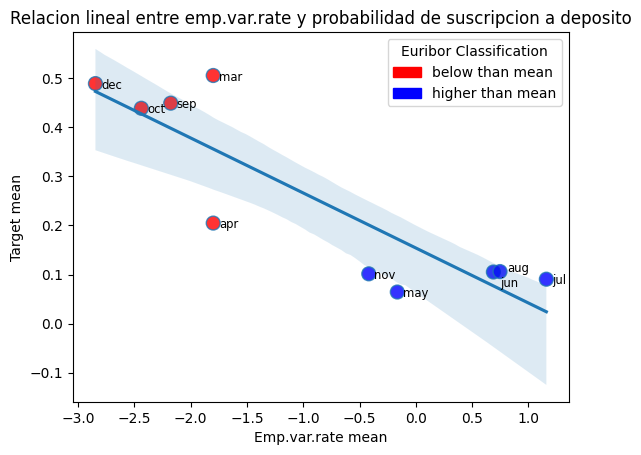

In [45]:
# mapeamos el color para diferenciar meses con bajo euribor vs alto euribor
color_map = {'below than mean': 'red', 'higher than mean': 'blue'}
test_emp_var_rate_gb['color'] = test_emp_var_rate_gb['euribor'].map(color_map)

sns.regplot(x='emp.var.rate', y='y', data=test_emp_var_rate_gb,
            scatter_kws={'s': 100,
                         'facecolors': test_emp_var_rate_gb['color']})
# Definir los desplazamientos para los meses específicos que se superponen
offsets = {
    'aug': (0.01, 0.01),
    'jun': (0.01, -0.02),
    # Añadir o modificar según sea necesario para otros meses
}
# Añadir etiquetas de texto para cada punto con ajustes
for index, row in test_emp_var_rate_gb.iterrows():
    # Obtener el desplazamiento si el mes requiere ajuste
    offset = offsets.get(row['month'], (0, 0))
    plt.text(row['emp.var.rate'] + offset[0] + 0.05, row['y'] + offset[1]-0.01, row['month'],
             horizontalalignment='left', size='small', color='black')

# Añadir leyenda manualmente
import matplotlib.patches as mpatches
legend_handles = [mpatches.Patch(color=color, label=euribor) for euribor, color in color_map.items()]
plt.legend(handles=legend_handles, title='Euribor Classification')

plt.xlabel('Emp.var.rate mean')
plt.ylabel('Target mean')
plt.title('Relacion lineal entre emp.var.rate y probabilidad de suscripcion a deposito')

plt.show()

# PRE-PRO

  * **Tratamiento de NaNs**.
  * **Feature Engineering**.

## Tratamiento de nans

In [46]:
df_nanImputer = df.copy()

# calculamos el promedio de nans en las columnas que poseen datos faltantes
columns_w_nans = [col for col in df_nanImputer.columns if df_nanImputer[col].isna().any()]
df_nanImputer[columns_w_nans].isna().mean()

job          0.008012
marital      0.001942
education    0.042027
default      0.208726
housing      0.024036
loan         0.024036
dtype: float64

**housing**

In [47]:
# agregamos un label para indicar valor nulo
df_nanImputer["housing"] = df_nanImputer["housing"].fillna("missing")

# pareciera no haber diferencia entre valores nulos y valor del target
df_nanImputer.groupby("housing")["y"].value_counts(normalize=True)

housing  y  
missing  no     0.891919
         yes    0.108081
no       no     0.891204
         yes    0.108796
yes      no     0.883806
         yes    0.116194
Name: y, dtype: float64

**loan**

In [48]:
# agregamos un label para indicar valor nulo
df_nanImputer["loan"] = df_nanImputer["loan"].fillna("missing")

# pareciera no haber diferencia entre valores nulos y valor del target
df_nanImputer.groupby("loan")["y"].value_counts(normalize=True)

loan     y  
missing  no     0.891919
         yes    0.108081
no       no     0.886598
         yes    0.113402
yes      no     0.890685
         yes    0.109315
Name: y, dtype: float64

**Marital**

In [49]:
# agregamos un label para indicar valor nulo
df_nanImputer["marital"] = df_nanImputer["marital"].fillna("missing")

**Job**



In [50]:
# calculamos la moda
job_mode = df_nanImputer["job"].mode()

# imputamos los nans en jobs por la moda
df_nanImputer["job"] = df_nanImputer["job"].fillna(job_mode[0])

**Education**

In [51]:
# calculamos la moda
education_mode = df_nanImputer["education"].mode()[0]

# imputamos los nans en educations por la moda
df_nanImputer["education"] = df_nanImputer["education"].fillna(education_mode)

**default**

In [52]:
df_nanImputer["default"] = df_nanImputer["default"].fillna("missing")

## Feature engineering

In [53]:
df_ = df_nanImputer.copy()

**pday-bin**

In [54]:
# Definimos los bins para los 7 intervalos
bins = [0, 3, 7, 999, np.inf]

# Creamos etiquetas para los intervalos para una mejor interpretación
interval_labels = ['0-3', '4-7', '7+', '999']

# Usamos pd.cut para clasificar los valores en los bins
# El parámetro include_lowest=True asegura que el primer intervalo sea cerrado por ambos lados
categories = pd.cut(df_.pdays.unique(), bins=bins, labels=interval_labels, include_lowest=True)

# Creamos un DataFrame para ver los resultados más claramente
df_intervals = pd.DataFrame({'values': df_.pdays.unique(),
                             'pdays_bin': categories})

df_ = pd.merge(df_, df_intervals[["values", "pdays_bin"]], left_on="pdays", right_on="values", how="left")

In [55]:
# crear feature binario tq indique si dicho cliente fue contactado o no
df_["client_contacted"] = np.where(df_.pdays == 999, 1, 0)

**Euribor**

In [56]:
df_["type_euribor"] = np.where(df_.euribor3m < df_.euribor3m.mean(), "below than mean", "higher than mean")

**Probabilidades condicionales**

In [57]:
# calculamos P(A|B) donde B = "job"
prob_cond_job = calculate_prob_cond(df_, "y", "job")
df_["P(A|B)_job"] = pd.merge(df_, prob_cond_job[["label", "P(A|B)"]],
                             left_on="job", right_on="label", how="left")["P(A|B)"]
df_[["P(A|B)_job", "job"]].head()

,P(A|B)_job,job
0,0.100000,housemaid
1,0.081381,services
2,0.081381,services
3,0.129185,admin.
4,0.081381,services


In [58]:
# calculamos P(A|B) donde B = "education"
prob_cond_education = calculate_prob_cond(df_, "y", "education")
df_["P(A|B)_education"] = pd.merge(df_, prob_cond_education[["label", "P(A|B)"]],
                             left_on="education", right_on="label", how="left")["P(A|B)"]
df_[["P(A|B)_education", "education"]].head()

,P(A|B)_education,education
0,0.102490,basic.4y
1,0.108355,high.school
2,0.108355,high.school
3,0.082024,basic.6y
4,0.108355,high.school


In [59]:
# calculamos P(A|B) donde B = "pdays_bin"
prob_cond_pdays_bin = calculate_prob_cond(df_, "y", "pdays_bin")
df_["P(A|B)_pdays_bin"] = pd.merge(df_, prob_cond_pdays_bin[["label", "P(A|B)"]],
                             left_on="pdays_bin", right_on="label", how="left")["P(A|B)"]
df_[["P(A|B)_pdays_bin", "pdays_bin"]].head()

,P(A|B)_pdays_bin,pdays_bin
0,0.096623,7+
1,0.096623,7+
2,0.096623,7+
3,0.096623,7+
4,0.096623,7+


In [60]:
# calculamos P(A|B) donde B = "poutcome"
prob_cond_poutcome = calculate_prob_cond(df_, "y", "poutcome")
df_["P(A|B)_poutcome"] = pd.merge(df_, prob_cond_poutcome[["label", "P(A|B)"]],
                             left_on="poutcome", right_on="label", how="left")["P(A|B)"]
df_[["P(A|B)_poutcome", "poutcome"]].head()

,P(A|B)_poutcome,poutcome
0,0.088322,nonexistent
1,0.088322,nonexistent
2,0.088322,nonexistent
3,0.088322,nonexistent
4,0.088322,nonexistent


# MODELADO


In [61]:
features_prob_cond = ['P(A|B)_job', 'P(A|B)_education', 'P(A|B)_pdays_bin', 'P(A|B)_poutcome']

features_categoricos = ["job", "poutcome", "pdays_bin", "month", "education", "default", "type_euribor"]

features_numericos = ["pdays", "euribor3m", "cons.price.idx", "client_contacted", "emp.var.rate", "nr.employed",
                      "campaign", "cons.conf.idx"]


X = df_[features_categoricos+features_numericos+features_prob_cond].copy()
y = np.where(df_["y"] == "yes", 1, 0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# declaramos un ordinal encoder para poder codificiar los features categoricos
oe = OrdinalEncoder()
ohe = OneHotEncoder(sparse_output=False)

ct = ColumnTransformer(transformers=[
                              ("oe", oe, ["pdays_bin", "month", "education"]),
                              ("ohe", ohe, ["job", "poutcome","default", "type_euribor"])
                      ], remainder='passthrough')

# entrenamos el transformador de columnas y transformar los datos de entrenamiento
ct.fit(X_train)

ct.set_output(transform="pandas")

X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

encoded_feats=[col for col in X_train_enc.columns if col.startswith("ohe")]


num_feats = [col for col in X_train_enc.columns if col.startswith("remainder")]

**KNN**

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10968
           1       0.58      0.26      0.36      1389

    accuracy                           0.90     12357
   macro avg       0.74      0.62      0.65     12357
weighted avg       0.88      0.90      0.88     12357

Precisión (KNeighbors): 0.8955248037549567


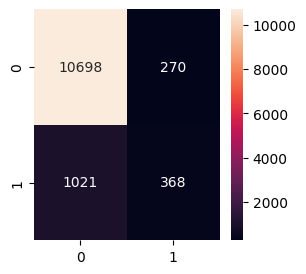

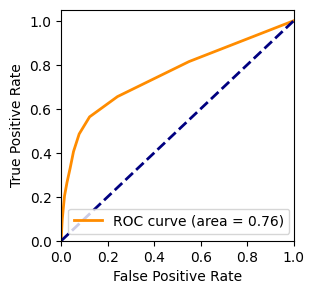

In [62]:
# escalamos los daos puesto que knn funcina mejor escalando los datos
scl = StandardScaler()
scl.fit(X_train_enc[num_feats+encoded_feats])

X_train_scaled= scl.transform(X_train_enc[num_feats+encoded_feats])
X_test_scaled = scl.transform(X_test_enc[num_feats+encoded_feats])

# definimos el clasificador
knn = KNeighborsClassifier(metric="manhattan", n_neighbors=13, weights="uniform")

# obtenemos metricas
obtain_metrics(knn, X_train_scaled, X_test_scaled, y_train, y_test)

**RANDOM FOREST**

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10968
           1       0.67      0.22      0.33      1389

    accuracy                           0.90     12357
   macro avg       0.79      0.60      0.64     12357
weighted avg       0.88      0.90      0.88     12357

Precisión (KNeighbors): 0.9000566480537348


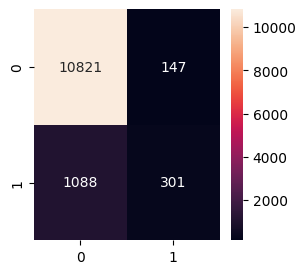

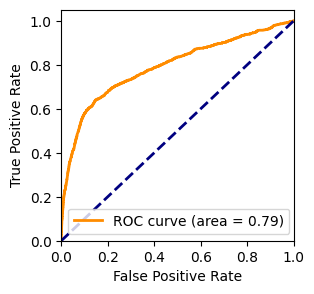

In [63]:
# definimos el clasificador
clf = RandomForestClassifier(max_depth= 10, min_samples_leaf= 1,
                             min_samples_split= 10, bootstrap = True,
                             n_estimators= 100)

# obtenemos las metricas
obtain_metrics(clf, X_train_enc, X_test_enc, y_train, y_test)

**XGBoost**

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10968
           1       0.68      0.19      0.30      1389

    accuracy                           0.90     12357
   macro avg       0.79      0.59      0.62     12357
weighted avg       0.88      0.90      0.87     12357

Precisión (KNeighbors): 0.899166464352189


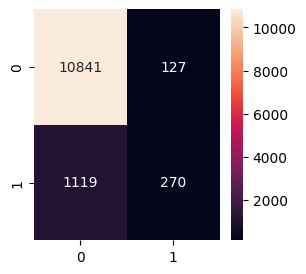

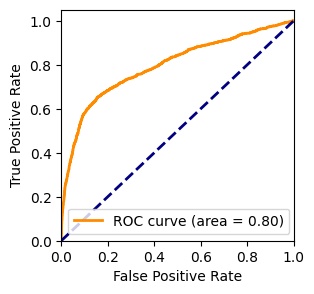

In [64]:
# declaramos el clasificador
xgb_clf = XGBClassifier(subsample= 0.6, n_estimators= 300,
                        min_child_weight= 2,
                        max_depth= 5, learning_rate= 0.01,
                        gamma= 0.4, colsample_bytree= 1.0)

# obtenemos las metricas
obtain_metrics(xgb_clf, X_train_enc, X_test_enc, y_train, y_test)

**RF con Sobremuestreo de la Clase Minoritaria**

              precision    recall  f1-score   support

           0       0.94      0.89      0.92     10968
           1       0.40      0.58      0.47      1389

    accuracy                           0.86     12357
   macro avg       0.67      0.74      0.70     12357
weighted avg       0.88      0.86      0.87     12357

Precisión (KNeighbors): 0.8556283887675002


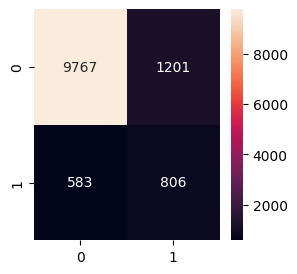

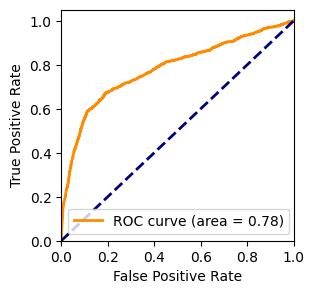

In [65]:
# implementamos el sobremuestreo
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_enc, y_train)

# declaramos el clasificador
rf_smote = RandomForestClassifier(max_depth= 10, min_samples_leaf= 1,
                                  min_samples_split= 10, bootstrap = True,
                                  n_estimators= 100)

# obtenemos metricas
obtain_metrics(rf_smote, X_train_smote, X_test_enc, y_train_smote, y_test)

**XGBoost con Sobremuestreo de la Clase Minoritaria**

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     10968
           1       0.39      0.59      0.47      1389

    accuracy                           0.85     12357
   macro avg       0.67      0.74      0.69     12357
weighted avg       0.88      0.85      0.86     12357

Precisión (KNeighbors): 0.8509346928866229


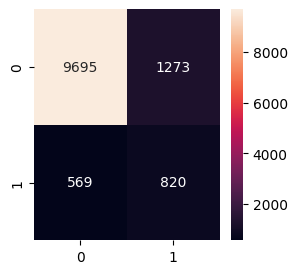

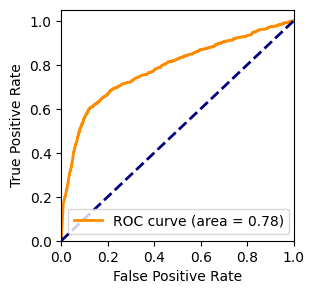

In [66]:
# declaramos el clasificador
xgb_clf_smote = XGBClassifier(subsample= 0.6, n_estimators= 300,
                        min_child_weight= 2,
                        max_depth= 5, learning_rate= 0.01,
                        gamma= 0.4, colsample_bytree= 1.0)

# obtenemos metricas
obtain_metrics(xgb_clf_smote, X_train_smote, X_test_enc, y_train_smote, y_test)

**Summary modelos**

Vemos que el modelo es muy bueno para predecir aquellos clientes que NO se suscriben a los depósitos, llegando a tener una **precisión** = 0.91 y un **recall** = 0.99 para la predicción de clientes que NO se suscriben.

En cuanto a los clientes que SI se suscriben, vemos que las métricas no suelen ser tan óptimas como para la clase negativa, esto puede deberse a que tenemos un solo 10% de observaciones que pertenecen a clientes suscriptos.

Por esto mismo se decidió hacer un **sobre-sampleo en la clase minoritaria** para poder aumentar las métricas cuando se intenta **predecir clientes suscriptos**.

Al hacer este sobre sampleo obtenemos un mejor recall a costa de bajar la precisión. Esta decisión dependerá de cuál es el objetivo que busca la empresa en sus clientes.

* Ejm1: Si la empresa busca **activar campañas de marketing** en los **clientes con menor probabilidad de suscripción** a depósitos $\Rightarrow$ tanto el modelo de Random Forest como XGBoost (**SIN sobre samplear la clase minoritaria**) obtienen muy buenas métricas para predecir dichos tipos de clientes.

* Ejm2: Por el contrario, si la empresa busca **retener los clientes que con mayor probabilidad de suscribirse** $\Rightarrow$ Tanto Random Forest como XGBoost con sobre-sampleo ofrecen primeros resultados interesantes. A su vez, dependiendo la decisión de la empresa, se puede bajar el umbral de decisión para clientes suscriptos y así poder captar aún más clientes suscriptos (**Recall**) a costa de **bajar la precisión**.

Próximos pasos:
* Hacer análisis de los clientes que pertenecen tanto a los **falsos negativos** como los que fueron **falsos positivos**, así entender posibles errores del modelo.
* Incorporar nuevos features.